In [1]:
# Standard library imports
import os

# Contributed library imports
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Our imports
from multiview_mapping_toolkit.cameras.derived_cameras import MetashapeCameraSet
from multiview_mapping_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_mapping_toolkit.segmentation import (
    LookUpSegmentor,
    SegmentorPhotogrammetryCameraSet,
)

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set constants
You should be able to define most of the behavior from these constants

In [2]:
training_sites = ["chips", "delta"]
prediction_site_name = "valley"

In [3]:
## Parameters to control the outputs
# Repeat the labeling process
RETEXTURE = False
# Points less than this height (meters) above the DTM are considered ground
HEIGHT_ABOVE_GROUND_THRESH = 2
# The image is downsampled to this fraction for accelerated rendering
RENDER_IMAGE_SCALE = 0.25
# Cameras within this distance of the traing data are used in the rendering process
BUFFER_RADIUS_METERS = 50
# Downsample target
DOWNSAMPLE_TARGET = 1
# Image downsample factor for aggregation
AGGREGATE_IMAGE_SCALE = 0.25

## Python interpreter and script locations
MMSEG_UTILS_PYTHON = "/ofo-share/repos-david/conda/envs/mmseg-utils/bin/python"
MMSEG_PYTHON = "/ofo-share/repos-david/conda/envs/openmmlab/bin/python"

FOLDER_TO_CITYSCAPES_SCRIPT = "/ofo-share/repos-david/mmsegmentation_utils/dev/dataset_creation/folder_to_cityscapes.py"
VIS_PREDS_SCRIPT = "/ofo-share/repos-david/mmsegmentation_utils/dev/visualization/visualize_semantic_labels.py"
TRAIN_SCRIPT = "/ofo-share/repos-david/mmsegmentation/tools/train.py"
INFERENCE_SCRIPT = "/ofo-share/repos-david/mmsegmentation/tools/inference.py"

# One folder up from scripts
PROJECT_ROOT = Path(os.path.abspath(""), "..", "..", "..").resolve()
SCRATCH_ROOT = Path(Path.home(), "scratch", "organized_str_disp_MVMT_experiments")

IDs_TO_LABELS = {
    0: "ABCO",
    1: "CADE",
    2: "PILA",
    3: "PIPO",
    4: "PSME",
    5: "QUEV",
    6: "SNAG",
    7: "ground",
}

TRAINING_SITES_STR = "_".join(training_sites)

## Define the inputs
# The input labels
LABELS_FILENAME = Path(PROJECT_ROOT, "field_ref", "crowns_drone_w_field_data.geojson")

# The digital elevation map exported by Metashape
DTM_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "02_photogrammetry",
    "exports",
    "dtms",
    f"{prediction_site_name}.tif",
)
IMAGES_NEAR_LABELS_FOLDER = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "03_training_data",
    "images_near_labels",
)
prediction_site_long_name = {"valley": "ValleyA", "chips": "ChipsB", "delta": "DeltaB"}[
    prediction_site_name
]
IMAGE_FOLDER = f"/ofo-share/str-disp_drone-data-partial/str-disp_drone-data_imagery-missions/{prediction_site_long_name}"
PREDICTIONS_FOLDER = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "04_model_preds",
    f"{TRAINING_SITES_STR}_MVMT_model",
)
PREDICTED_VECTOR_LABELS_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "05_processed_predictions",
    f"{prediction_site_name}_80m_chips_model.geojson",
)
NUMPY_EXPORT_FACES_TEXTURE_FILE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "05_processed_predictions",
    f"{prediction_site_name}_80m_chips_model.npy",
)

In [4]:
MESH_FILENAME_BASE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "02_photogrammetry",
    "exports",
    "meshes",
)

CHIPS_MESH_FILENAME = Path(
    MESH_FILENAME_BASE,
    "ChipsB-120m_20230309T0502_w-mesh_w-80m_20231114T2219.ply",
)
# The mesh exported from Metashape
DELTA_MESH_FILENAME = Path(
    MESH_FILENAME_BASE,
    "DeltaB-120m_20230310T1701_w-mesh_w-80m_20231117T1746.ply",
)
# The mesh exported from Metashape
VALLEY_MESH_FILENAME = Path(
    MESH_FILENAME_BASE,
    "ValleyA-120m_20230323T0515_w-mesh.ply",
)
# The camera file exported from Metashape
CAMERAS_FILENAME_BASE = Path(
    PROJECT_ROOT,
    "per_site_processing",
    prediction_site_name,
    "02_photogrammetry",
    "exports",
    "cameras",
)
CHIPS_CAMERAS_FILENAME = Path(
    CAMERAS_FILENAME_BASE,
    "ChipsB-120m_20230309T0502_w-mesh_w-80m_20231114T2219_abs_paths.xml",
)
# The camera file exported from Metashape
DELTA_CAMERAS_FILENAME = Path(
    CAMERAS_FILENAME_BASE,
    "DeltaB-120m_20230310T1701_w-mesh_w-80m_20231117T1746_abs_paths.xml",
)
# The camera file exported from Metashape
VALLEY_CAMERAS_FILENAME = Path(
    CAMERAS_FILENAME_BASE,
    "ValleyA-120m_20230323T0515_w-mesh.xml",
)

MESH_FILENAME_DICT = {
    "chips": CHIPS_MESH_FILENAME,
    "delta": DELTA_MESH_FILENAME,
    "valley": VALLEY_MESH_FILENAME,
}
CAMERAS_FILENAME_DICT = {
    "chips": CHIPS_CAMERAS_FILENAME,
    "delta": DELTA_CAMERAS_FILENAME,
    "valley": VALLEY_CAMERAS_FILENAME,
}

MESH_FILENAME = MESH_FILENAME_DICT[prediction_site_name]
CAMERAS_FILENAME = CAMERAS_FILENAME_DICT[prediction_site_name]

# Aggregate predictions

In [5]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
    IDs_to_labels=IDs_TO_LABELS,
)
print("Done creating mesh")

Loading transform to EPSG:4326


Loading mesh
Reading the mesh
Selecting an ROI from mesh
Standardizing ROI
Dissolving ROI
Setting CRS and buffering ROI
Dissolving buffered ROI
Extracting verts for dataframe
Checking intersection of verts with ROI


/ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/valley/02_photogrammetry/exports/cameras/ValleyA-120m_20230323T0515_w-mesh.xml


Loading GPS data for camera set: 100%|██████████| 9452/9452 [00:00<00:00, 2151321.98it/s]


About to vis
This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


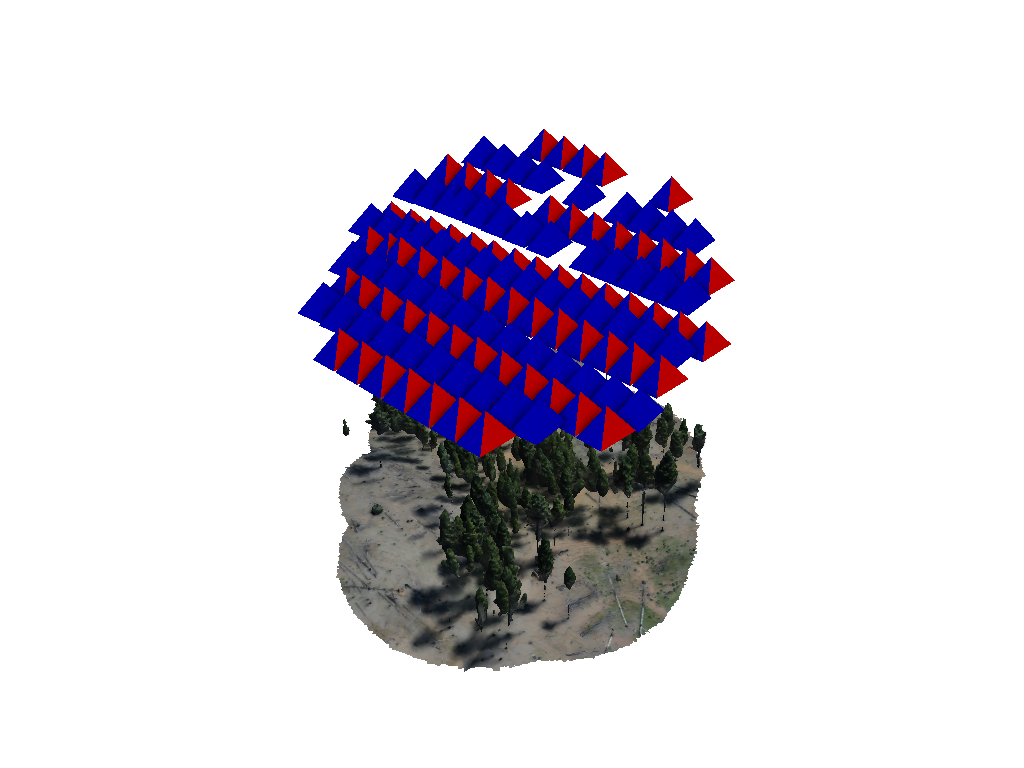

In [ ]:
# Create camera set
print(CAMERAS_FILENAME)
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_ROI(
    ROI=LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METERS
)
print("About to vis")
# %%
mesh.vis(camera_set=training_camera_set, force_xvfb=True)

In [ ]:
# %%
segmentor = LookUpSegmentor(
    base_folder=IMAGE_FOLDER,
    lookup_folder=PREDICTIONS_FOLDER,
    num_classes=8,
)

segmentor_camera_set = SegmentorPhotogrammetryCameraSet(
    training_camera_set, segmentor=segmentor
)

aggregated_face_labels, _, _ = mesh.aggregate_viewpoints_pytorch3d(
    segmentor_camera_set,
    image_scale=AGGREGATE_IMAGE_SCALE,
)

Aggregating information from different viewpoints:  50%|████▉     | 62/125 [02:42<02:29,  2.37s/it]

Sampling values from raster /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/valley/02_photogrammetry/exports/dtms/valley.tif:   0%|          | 0/134102 [00:00<?, ?it/s]

Sampling values from raster /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/valley/02_photogrammetry/exports/dtms/valley.tif: 100%|██████████| 134102/134102 [00:05<00:00, 24842.18it/s]


This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


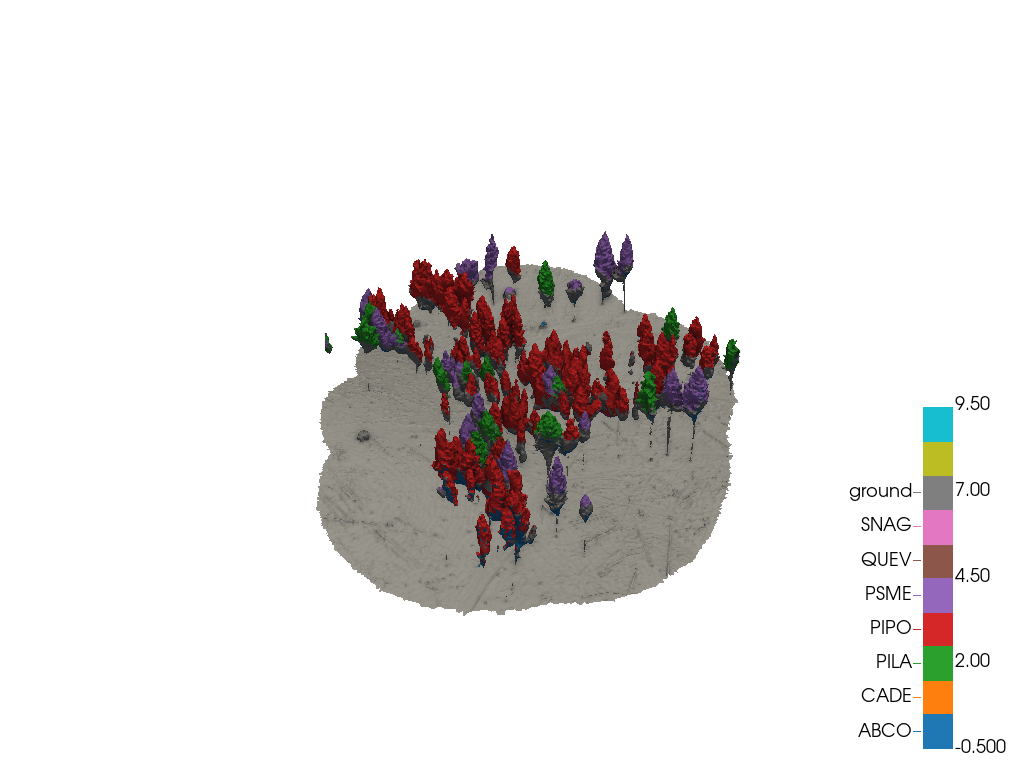

Computing working CRS
Computing faces in working CRS


Converting faces to polygons: 100%|██████████| 266363/266363 [00:04<00:00, 59618.63it/s]

Creating dataframe of faces


Creating dataframe of multipolygons


Computing batched unary union with batch size 500000: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]
Computing batched unary union with batch size 500000: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]
Computing batched unary union with batch size 500000: 100%|██████████| 1/1 [00:06<00:00,  6.91s/it]
Computing batched unary union with batch size 500000: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]
Computing batched unary union with batch size 500000: 100%|██████████| 1/1 [00:00<00:00, 601.25it/s]
Computing batched unary union with batch size 500000: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it]


Ensuring non-overlapping polygons
Plotting


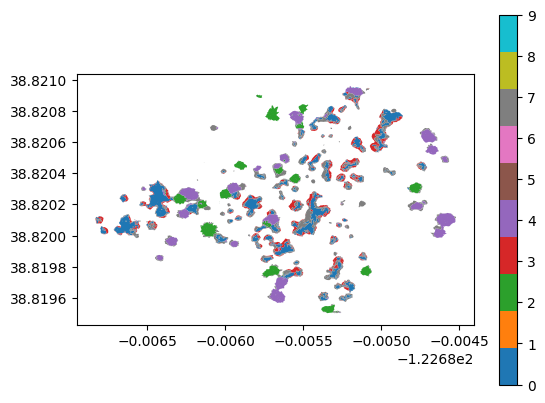

,class_ID,geometry
0,0.0,"MULTIPOLYGON (((-122.68641 38.81985, -122.6864..."
1,2.0,"MULTIPOLYGON (((-122.68605 38.82001, -122.6860..."
2,3.0,"MULTIPOLYGON (((-122.68603 38.82001, -122.6860..."
3,4.0,"MULTIPOLYGON (((-122.68643 38.81984, -122.6864..."
4,6.0,"MULTIPOLYGON (((-122.68514 38.82018, -122.6851..."
5,7.0,"MULTIPOLYGON (((-122.68661 38.82000, -122.6866..."


In [ ]:
# %%
predicted_face_classes = np.argmax(
    aggregated_face_labels, axis=1, keepdims=True
).astype(float)
predicted_face_classes = mesh.label_ground_class(
    labels=predicted_face_classes,
    height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
    DTM_file=DTM_FILE,
    ground_ID=np.nan,
    set_mesh_texture=False,
)
NUMPY_EXPORT_FACES_TEXTURE_FILE.parent.mkdir(parents=True, exist_ok=True)
np.save(NUMPY_EXPORT_FACES_TEXTURE_FILE, predicted_face_classes)
# %%
mesh.vis(
    vis_scalars=predicted_face_classes,
    force_xvfb=True,
)

mesh.export_face_labels_vector(
    face_labels=np.squeeze(predicted_face_classes),
    export_file=PREDICTED_VECTOR_LABELS_FILE,
    vis=True,
    vis_kwargs={"cmap": "tab10", "vmin": -0.5, "vmax": 9.5},
)

# Show the ground truth labeling

Loading transform to EPSG:4326


Loading mesh
Reading the mesh
Selecting an ROI from mesh
Standardizing ROI
Dissolving ROI
Setting CRS and buffering ROI
Dissolving buffered ROI
Extracting verts for dataframe
Checking intersection of verts with ROI
Extracting points from pyvista mesh
Extraction surface from subset mesh
Extracting faces from mesh
Loading texture
Could not read texture as a scalar from the pyvista mesh
Could not read texture as a numpy file


Sampling values from raster /ofo-share/scratch-david/organized-str-disp-MVMT-experiments/per_site_processing/valley/02_photogrammetry/exports/dtms/valley.tif: 100%|██████████| 134102/134102 [00:05<00:00, 23876.60it/s]


This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


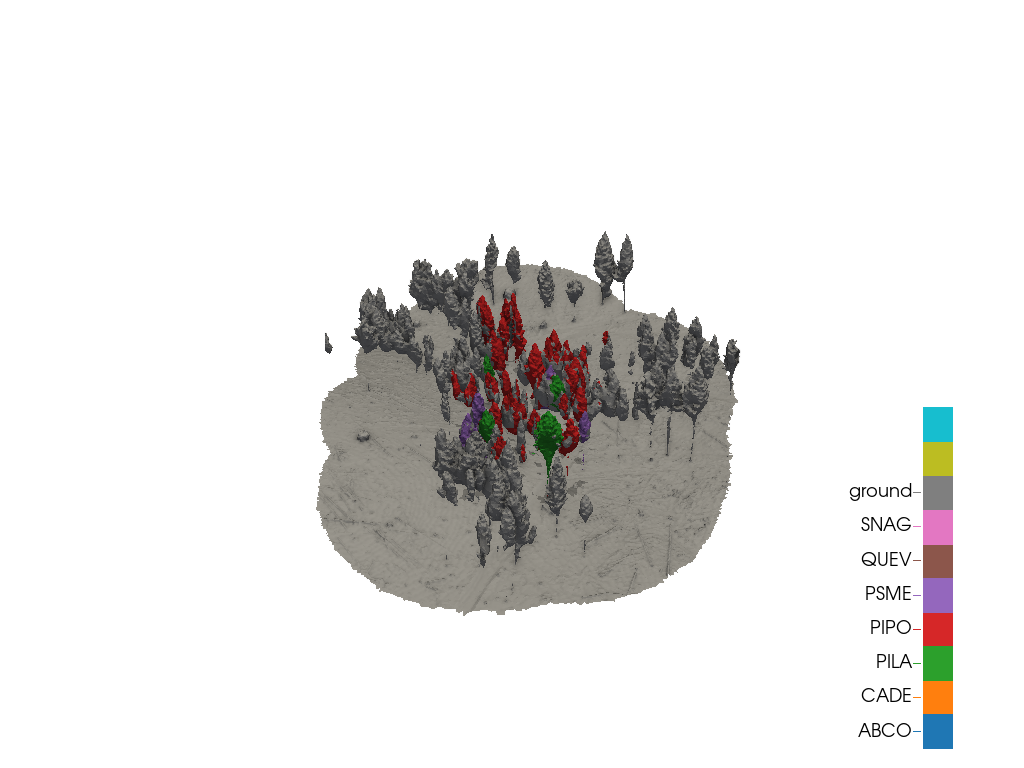

In [ ]:
LABELS_COLUMN = "species_observed"
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    texture=LABELS_FILENAME,
    texture_column_name=LABELS_COLUMN,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.label_ground_class(
    height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
    DTM_file=DTM_FILE,
    set_mesh_texture=True,
)
mesh.vis(force_xvfb=True)